In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# build MultiScaleDeformableAttention
!cd /content/drive/MyDrive/models/dino/ops
!export TORCH_CUDA_ARCH_LIST="7.5;8.0;8.6;8.9"   # 7.5 for grand-challenge's online GPU (T4), 8.6 for 3090
!python /content/drive/MyDrive/models/dino/ops/setup.py build install

running build
running build_ext
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:529: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:448: UserWarning: The detected CUDA version (12.5) has a minor version mismatch with the version that was used to compile PyTorch (12.4). Most likely this shouldn't be a problem.
  warnings.warn(CUDA_MISMATCH_WARN.format(cuda_str_version, torch.version.cuda))
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:458: UserWarning: There are no x86_64-linux-gnu-g++ version bounds defined for CUDA version 12.5
  warnings.warn(f'There are no {compiler_name} version bounds defined for CUDA version {cuda_str_version}')
building 'MultiScaleDeformableAttention' extension
creating build/temp.linux-x86_64-cpyth

In [1]:
!pip install SimpleITK fvcore ultralytics addict yapf==0.31.0 tqdm pycocotools

DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/MultiScaleDeformableAttention-1.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.7/185.7 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [7]:
import sys
sys.path.append("/content/drive/MyDrive/")

In [3]:
import glob
import numpy as np
import os
import cv2
from tqdm import tqdm
import sys

import json
import torch
from PIL import Image
import SimpleITK as sitk
from torchvision import transforms as T
from torchvision.transforms import functional as F
from torchvision.ops import box_iou
from detectron2.config import get_cfg
from detectron2.engine.defaults import DefaultPredictor
from models.diffusiondet import DiffusionDetDatasetMapper, add_diffusiondet_config, DiffusionDetWithTTA
from models.diffusiondet.util.model_ema import add_model_ema_configs
from ultralytics import YOLO
from models.unet.utils import load_unet, load_seunet
from util.slconfig import SLConfig

from util.weighted_boxes_fusion import weighted_boxes_fusion
import models.dino.datasets.transforms as DT
import argparse
import torch.serialization
torch.serialization.add_safe_globals([argparse.Namespace])
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

quadrant_remap = {
    0: 1,
    1: 0,
    2: 2,
    3: 3,
}

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [10]:
def build_model_main(args):
    from models.registry import MODULE_BUILD_FUNCS

    assert args.modelname in MODULE_BUILD_FUNCS._module_dict
    build_func = MODULE_BUILD_FUNCS.get(args.modelname)
    model, criterion, postprocessors = build_func(args)
    return model, criterion, postprocessors

In [16]:
class DinoDetectionPredictor:
    def __init__(self, args, model_checkpoint_path, score_threshold, cuda=True, mean=None, std=None) -> None:
        model, criterion, postprocessors = build_model_main(args)
        checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
        model.load_state_dict(checkpoint["model"])
        self.cuda = cuda
        if cuda:
            model = model.cuda()
        model.eval()
        self.model = model
        self.postprocessors = postprocessors

        self.transform = DT.Compose(
            [
                DT.RandomResize([800], max_size=1333),
                DT.ToTensor(),
                DT.Normalize(
                    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
                ),  # the origin config, maybe different from the dentex dataset
            ]
        )
        self.score_threshold = score_threshold

    def predict(self, image: np.ndarray):
        image_shape = image.shape[:2]
        image = Image.fromarray(image)
        image, _ = self.transform(image, None)
        if self.cuda:
            image = image.cuda()
        outputs = self.model(image.unsqueeze(0))
        scale = torch.tensor([image_shape])
        if self.cuda:
            scale = scale.cuda()
        output = self.postprocessors["bbox"](outputs, scale)[0]
        scores = output["scores"]
        labels = output["labels"]
        boxes = output["boxes"]
        select_mask = scores > self.score_threshold

        scores = scores[select_mask]
        labels = labels[select_mask]
        boxes = boxes[select_mask]

        return {
            "scores": scores,
            "labels": labels,
            "boxes": boxes,
        }

In [ ]:
!pip install addict

DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/MultiScaleDeformableAttention-1.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [ ]:
!pip install yapf==0.31.0

DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/MultiScaleDeformableAttention-1.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.7/185.7 kB 22.1 MB/s eta 0:00:00


In [ ]:
# train dino res50 enumeration32 detection
!python /content/drive/MyDrive/train_dino.py \
	--output_dir /content/drive/MyDrive/output_dino_res50_enum32 -c /content/drive/MyDrive/configs/dino/DINO_4scale_cls32.py --coco_path /content/drive/MyDrive/dentex_dataset/coco/enumeration32 \
	--options dn_scalar=100 embed_init_tgt=TRUE \
	dn_label_coef=1.0 dn_bbox_coef=1.0 use_ema=False \
	dn_box_noise_scale=1.0 \
	--pretrain_model_path /content/drive/MyDrive/checkpoints/dino_pretrained_checkpoint0033_4scale.pth --finetune_ignore label_enc.weight class_embed

Output hidden; open in https://colab.research.google.com to view.

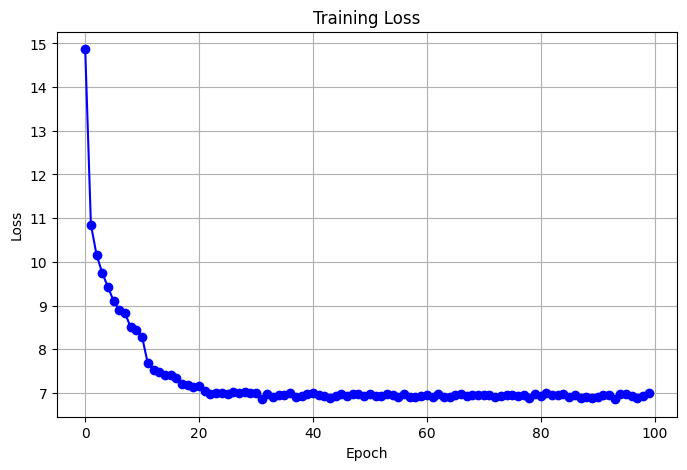

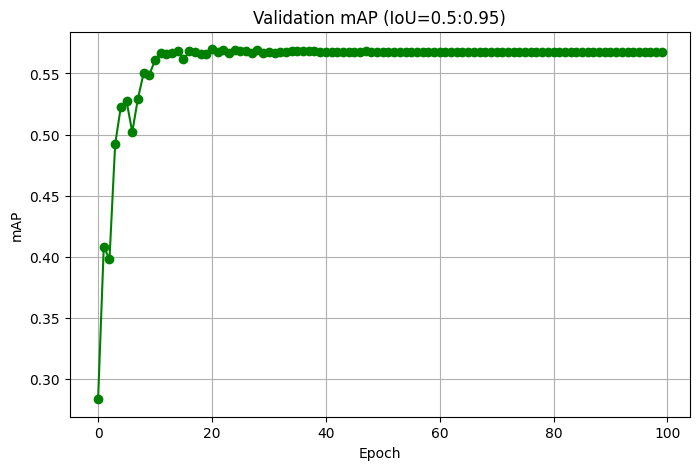

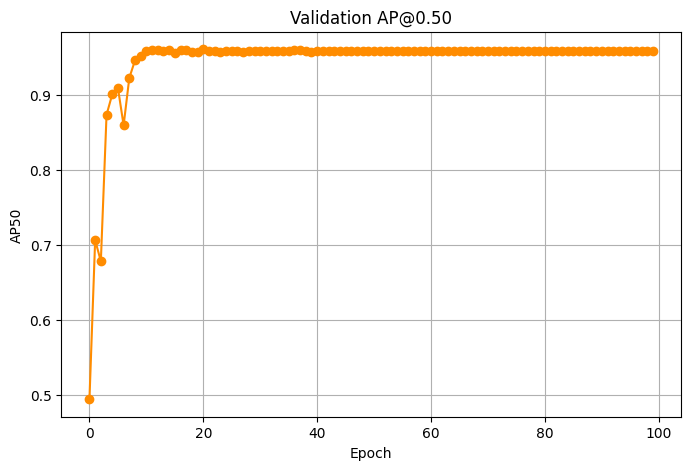

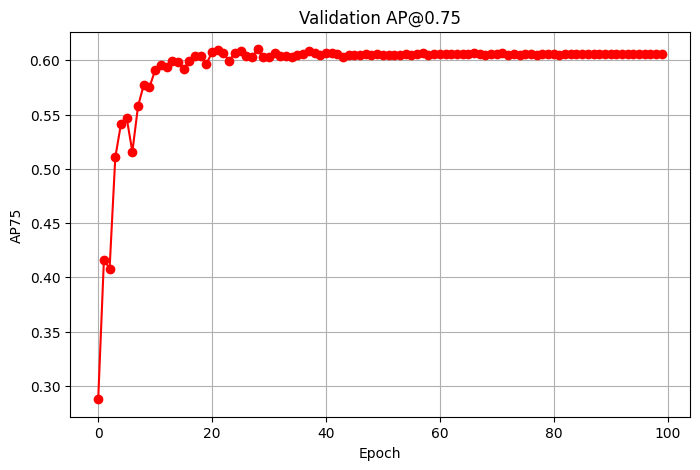

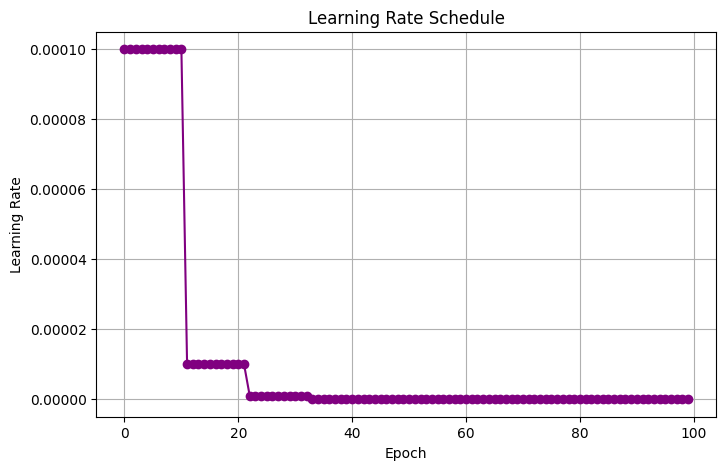

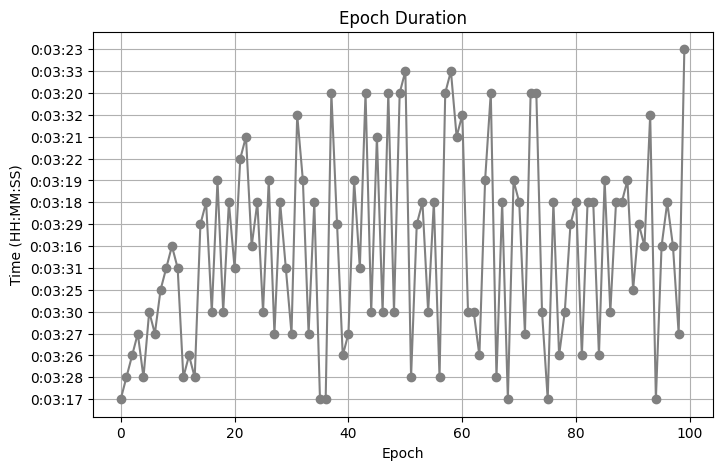

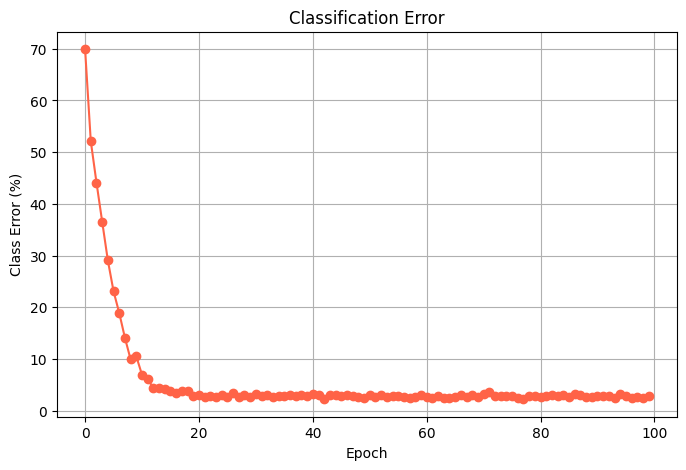

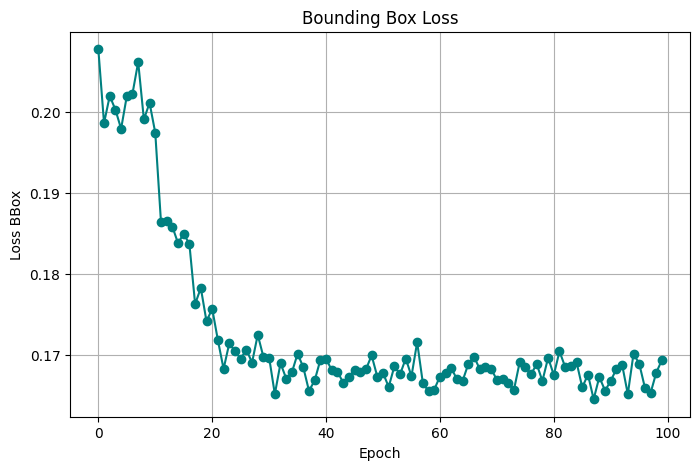

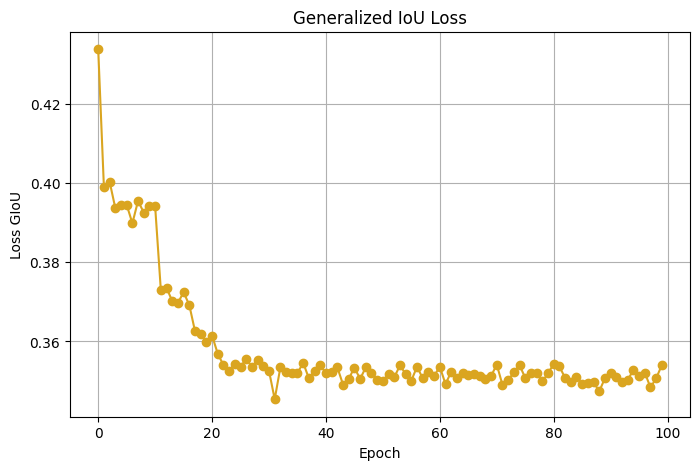

In [ ]:
import json
import matplotlib.pyplot as plt
import os

# ==== Set path to your training log ====
log_path = "/content/drive/MyDrive/output_dino_res50_enum32/log.txt"  # <-- Your actual log path

# ==== Read and Parse Log ====
logs = []
with open(log_path, "r") as f:
    for line in f:
        try:
            logs.append(json.loads(line.strip()))
        except:
            continue

# ==== Extract Common Metrics ====
epochs = [log["epoch"] for log in logs if "epoch" in log]
train_loss = [log.get("train_loss", None) for log in logs]
val_map = [log.get("test_coco_eval_bbox", [None])[0] for log in logs]
ap50 = [log.get("test_coco_eval_bbox", [None, None])[1] for log in logs]
ap75 = [log.get("test_coco_eval_bbox", [None, None, None])[2] for log in logs]
lr = [log.get("train_lr", None) for log in logs]
epoch_time = [log.get("epoch_time", None) for log in logs]
class_error = [log.get("train_class_error", None) for log in logs]
bbox_loss = [log.get("train_loss_bbox", None) for log in logs]
giou_loss = [log.get("train_loss_giou", None) for log in logs]

# ==== Helper function for single plots ====
def plot_metric(x, y, title, ylabel, color="blue"):
    plt.figure(figsize=(8, 5))
    plt.plot(x, y, marker='o', color=color)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.show()

# ==== Core Plots ====
plot_metric(epochs, train_loss, "Training Loss", "Loss")
plot_metric(epochs, val_map, "Validation mAP (IoU=0.5:0.95)", "mAP", color="green")
plot_metric(epochs, ap50, "Validation AP@0.50", "AP50", color="darkorange")
plot_metric(epochs, ap75, "Validation AP@0.75", "AP75", color="red")
plot_metric(epochs, lr, "Learning Rate Schedule", "Learning Rate", color="purple")
plot_metric(epochs, epoch_time, "Epoch Duration", "Time (HH:MM:SS)", color="gray")

# ==== Advanced Metrics ====
plot_metric(epochs, class_error, "Classification Error", "Class Error (%)", color="tomato")
plot_metric(epochs, bbox_loss, "Bounding Box Loss", "Loss BBox", color="teal")
plot_metric(epochs, giou_loss, "Generalized IoU Loss", "Loss GIoU", color="goldenrod")


In [65]:
with torch.no_grad():
    confidence_threshold = 0.01
    cuda = True
    iou_match_threshold = 0.4
    enumeration_result_by_detector = {}
    enumeration_detector_config_path = "/content/drive/MyDrive/configs/dino/DINO_4scale_cls32.py"
    enumeration_detector_checkpoint_path = "/content/drive/MyDrive/output_dino_res50_enum32/checkpoint_best_regular.pth"
    enumeration_cfg = SLConfig.fromfile(enumeration_detector_config_path)
    enumeration_cfg.device = "cuda" if cuda else "cpu"
    enumeration_predictor = DinoDetectionPredictor(
        enumeration_cfg, enumeration_detector_checkpoint_path, 0.3, cuda=cuda
    )

In [66]:
import json
from tqdm import tqdm

# --- Load COCO Metadata ---
with open("/content/drive/MyDrive/enumeration32_Test/Dino_ResNet50/enum32_my_test.json", "r") as f:
    coco = json.load(f)

list_ids_final = []
for image_info in coco["images"]:
    list_ids_final.append({
        "file_name": image_info["file_name"],
        "height": image_info["height"],
        "width": image_info["width"],
        "id": image_info["id"]
    })

# --- Load PNG images into a dictionary ---
input_image_dir = "/content/drive/MyDrive/enumeration32_Test/Dino_ResNet50/Dino_ResNet50_Test"
image_array = {}
for item in tqdm(list_ids_final):
    img_path = os.path.join(input_image_dir, item["file_name"])
    img = cv2.imread(img_path)  # BGR
    if img is None:
        raise FileNotFoundError(f"Image not found: {img_path}")
    image_array[item["id"]] = img

# --- Inference and Save Predictions ---
results_per_image = {}  # image_id → predictions
coco_results = []       # final list for COCO format

print("task type: test")
with torch.no_grad():
    for entry in tqdm(list_ids_final):
        image_id = entry["id"]
        image_name = entry["file_name"]
        image_height = entry["height"]
        image_width = entry["width"]

        print(f"processing {image_name}, id {image_id}...")

        image_rgb_arr = image_array[image_id]
        image_rgb_arr = image_rgb_arr[:image_height, :image_width, :]
        image_bgr_arr = image_rgb_arr[:, :, ::-1]
        image_gray_arr = cv2.cvtColor(image_bgr_arr, cv2.COLOR_BGR2GRAY)

        enumeration_detector_prediction = enumeration_predictor.predict(image_rgb_arr)

        enumeration_result_by_detector = {}  # reset for each image

        for i in range(len(enumeration_detector_prediction["boxes"])):
            x1, y1, x2, y2 = enumeration_detector_prediction["boxes"][i].tolist()
            score = enumeration_detector_prediction["scores"][i].item()
            label = enumeration_detector_prediction["labels"][i].item() + 1  # convert to 1–32

            # Store in dictionary per image
            enumeration_result_by_detector[label] = {
                "bbox": [x1, y1, x2, y2],
                "score": score
            }

            # Append in COCO prediction format
            coco_results.append({
                "image_id": image_id,
                "category_id": label,
                "bbox": [x1, y1, x2 - x1, y2 - y1],
                "score": score
            })

        # Store full result per image
        results_per_image[image_id] = enumeration_result_by_detector

# --- Save the COCO-style prediction results for evaluation ---
output_path = "/content/drive/MyDrive/enumeration32_Test/Dino_ResNet50/enum32_pred_results.json"
with open(output_path, "w") as f:
    json.dump(coco_results, f, indent=4)

print(f"Saved COCO-format predictions to {output_path}")


100%|██████████| 123/123 [00:01<00:00, 122.89it/s]


task type: test


  1%|          | 1/123 [00:00<00:13,  9.29it/s]

processing train_106_png.rf.ac175929bf6c73f1cee3506a4a121d80.jpg, id 1...
processing train_162_png.rf.d810c16a2c9177b9a246af90d495d121.jpg, id 2...


  2%|▏         | 3/123 [00:00<00:13,  9.23it/s]

processing train_167_png.rf.06c1d672bc2b66679d8fc05784c185ba.jpg, id 3...
processing train_419_png.rf.a7eb8be40f86b13288a33eed113d003f.jpg, id 4...


  4%|▍         | 5/123 [00:00<00:12,  9.31it/s]

processing train_291_png.rf.b625019ddaea85efe8b6c7128a346e41.jpg, id 5...
processing train_275_png.rf.30c5ca0272ec6804ce9780d4c523225e.jpg, id 6...


  6%|▌         | 7/123 [00:00<00:12,  9.25it/s]

processing train_553_png.rf.67fbe5f999475111fa07f3492278daee.jpg, id 7...
processing train_140_png.rf.32d6588a18d82189fffdebb45fd6611e.jpg, id 8...


  7%|▋         | 9/123 [00:00<00:12,  9.28it/s]

processing train_614_png.rf.29c357d4867009c8aa20716b7c31aa70.jpg, id 9...
processing train_514_png.rf.986554788e1fc31d33a2be7d4855dda8.jpg, id 10...


  9%|▉         | 11/123 [00:01<00:12,  9.03it/s]

processing train_304_png.rf.5d53f4fae0e8aec63480654151966a38.jpg, id 11...
processing train_102_png.rf.4995be109236034242752d3953ba931f.jpg, id 12...


 11%|█         | 13/123 [00:01<00:11,  9.17it/s]

processing train_568_png.rf.e0b00b9f71455c9253310b4c7d9bfadb.jpg, id 13...
processing train_46_png.rf.149c28bdd4e5eedc74902c1165347547.jpg, id 14...


 12%|█▏        | 15/123 [00:01<00:11,  9.23it/s]

processing train_267_png.rf.b89d1e49f885755c82fa7552a3c408ee.jpg, id 15...
processing train_64_png.rf.cc544fb3568152eb2558c94f6fef74f8.jpg, id 16...


 14%|█▍        | 17/123 [00:01<00:11,  9.25it/s]

processing train_15_png.rf.b5d3e5405b88f6e5342351aa54f1dcc4.jpg, id 17...
processing train_547_png.rf.4b1791de9cb73626b980f0f561cc648e.jpg, id 18...


 15%|█▌        | 19/123 [00:02<00:11,  9.23it/s]

processing train_287_png.rf.fc6fb140a1b764895f8cfe9c1e7e03a9.jpg, id 19...
processing train_414_png.rf.0a374a8ece4408a9f2ca764136bd8060.jpg, id 20...


 17%|█▋        | 21/123 [00:02<00:11,  9.25it/s]

processing train_618_png.rf.86f8f7dddf6d8148bde4e71d66850f6d.jpg, id 21...
processing train_222_png.rf.a9d787c151a97e4e2a577b2e82ab1b38.jpg, id 22...


 19%|█▊        | 23/123 [00:02<00:10,  9.25it/s]

processing train_30_png.rf.4d8b6c6553e10d784bd53d0710d6292f.jpg, id 23...
processing train_321_png.rf.d2400a53e34c35bba35afcadf38154d8.jpg, id 24...


 20%|██        | 25/123 [00:02<00:10,  9.23it/s]

processing train_244_png.rf.2df06bb8ed83dd4f8d5186abc48121e0.jpg, id 25...
processing train_250_png.rf.bda94a5de99e7e3f66d215a79c80b6ca.jpg, id 26...


 22%|██▏       | 27/123 [00:02<00:10,  9.24it/s]

processing train_447_png.rf.8b3b91c4fd4982b2e716abbdc8b02627.jpg, id 27...
processing train_406_png.rf.d978133acb73e8bbd56aee4bab5bba47.jpg, id 28...


 24%|██▎       | 29/123 [00:03<00:10,  9.23it/s]

processing train_178_png.rf.6f876cc1a86eed7b6fcf78a75c7c8028.jpg, id 29...
processing train_556_png.rf.c8f87c4491a39bc0a801c7cf35c50e4c.jpg, id 30...


 25%|██▌       | 31/123 [00:03<00:09,  9.23it/s]

processing train_239_png.rf.cfbaaf8625c9bb23a4c87ba8810df73b.jpg, id 31...
processing train_524_png.rf.e29271659189c0fce9d513139688e1d5.jpg, id 32...


 27%|██▋       | 33/123 [00:03<00:09,  9.21it/s]

processing train_397_png.rf.044799265487918013f831e44e4d767b.jpg, id 33...
processing train_211_png.rf.20e23693f8712d56dd1c7ffc31742bd7.jpg, id 34...


 28%|██▊       | 35/123 [00:03<00:09,  9.21it/s]

processing train_145_png.rf.eb726efb2e766009436bd627249a698c.jpg, id 35...
processing train_439_png.rf.46468c8abca83c71d3d51bb236fac523.jpg, id 36...


 30%|███       | 37/123 [00:04<00:09,  9.16it/s]

processing train_266_png.rf.c1c6c3195bde0a0e5ad42d80583607a6.jpg, id 37...
processing train_130_png.rf.e8454fa68d57edf8d79b50be12b4409f.jpg, id 38...


 32%|███▏      | 39/123 [00:04<00:09,  9.20it/s]

processing train_316_png.rf.876d3f6717e8853304536bcb86db16f6.jpg, id 39...
processing train_186_png.rf.f290d513829ade700bb76c84aa4541a6.jpg, id 40...


 33%|███▎      | 41/123 [00:04<00:08,  9.24it/s]

processing train_504_png.rf.7f999246f47eb755066fca997591f183.jpg, id 41...
processing train_409_png.rf.05684c5d544cbc49440286cc0996c1c9.jpg, id 42...


 35%|███▍      | 43/123 [00:04<00:08,  9.26it/s]

processing train_388_png.rf.20c401da9e964fd536fa5906c4bf8e77.jpg, id 43...
processing train_548_png.rf.47551d3761a9f882ae8203c3dba12f56.jpg, id 44...


 37%|███▋      | 45/123 [00:04<00:08,  9.23it/s]

processing train_100_png.rf.4258909bc7d0f5962b7c19aec390a201.jpg, id 45...
processing train_154_png.rf.cce11039fba6b7adc0a2e8f861112f67.jpg, id 46...


 38%|███▊      | 47/123 [00:05<00:08,  9.11it/s]

processing train_92_png.rf.c94b1bdc93b8b3c7b7e699d6be75c3d9.jpg, id 47...
processing train_437_png.rf.15d78cb15c21ac88b882a1fc7f232559.jpg, id 48...


 40%|███▉      | 49/123 [00:05<00:08,  9.21it/s]

processing train_29_png.rf.4a51d7364e5aaa1bd5338d4c21fd3a7f.jpg, id 49...
processing train_99_png.rf.0a467004c8999a80eda0f87574837cef.jpg, id 50...


 41%|████▏     | 51/123 [00:05<00:07,  9.24it/s]

processing train_219_png.rf.3c93c9dda80d7355be2d4fc0ecac3997.jpg, id 51...
processing train_487_png.rf.502e8562d8f50d86bdba70cc8d16e0ed.jpg, id 52...


 43%|████▎     | 53/123 [00:05<00:07,  9.27it/s]

processing train_18_png.rf.2d960ecbc2387fbf7fc9c900bfa3940b.jpg, id 53...
processing train_157_png.rf.3372f71a60bb927369a7d5081a1501ad.jpg, id 54...


 45%|████▍     | 55/123 [00:05<00:07,  9.21it/s]

processing train_625_png.rf.8103685380453a5d2ab9ec9746a81a87.jpg, id 55...
processing train_396_png.rf.6d4ef0f510d72c3b68b83d3e31d6eb4f.jpg, id 56...


 46%|████▋     | 57/123 [00:06<00:07,  9.22it/s]

processing train_7_png.rf.372957333bfe68726695932157e89492.jpg, id 57...
processing train_32_png.rf.f8156cfba883d49c278f1daa97b087e6.jpg, id 58...


 48%|████▊     | 59/123 [00:06<00:06,  9.25it/s]

processing train_598_png.rf.03f88499bab1bb74fe73756375cf19fd.jpg, id 59...
processing train_204_png.rf.41bd8dc01073fc5004281abe96a10535.jpg, id 60...


 50%|████▉     | 61/123 [00:06<00:06,  9.20it/s]

processing train_581_png.rf.2ed93b07d8a402a48ee583820ee5b7ba.jpg, id 61...
processing train_557_png.rf.b454737a1ec0f30e360cc99d0ea8fddf.jpg, id 62...


 51%|█████     | 63/123 [00:06<00:06,  9.23it/s]

processing train_534_png.rf.e2085ee6aa01e9fcb8d269bf0de188cb.jpg, id 63...
processing train_117_png.rf.1cea0f93616efd623a7ee52f259a3219.jpg, id 64...


 53%|█████▎    | 65/123 [00:07<00:06,  9.21it/s]

processing train_390_png.rf.58369b03fded277deff27787f70c3039.jpg, id 65...
processing train_596_png.rf.e5baa14512a3f5452a7889ac638076cc.jpg, id 66...


 54%|█████▍    | 67/123 [00:07<00:06,  9.20it/s]

processing train_474_png.rf.82b8ebe307d78af9422808a879509fdc.jpg, id 67...
processing train_401_png.rf.157dc6c895ec4849b13709f7eaf66aea.jpg, id 68...


 56%|█████▌    | 69/123 [00:07<00:05,  9.22it/s]

processing train_459_png.rf.0d2529bbecc443801cc8e8fe3b8b9fe0.jpg, id 69...
processing train_500_png.rf.4eb3439299442cf4c2937c65edd7c377.jpg, id 70...


 58%|█████▊    | 71/123 [00:07<00:05,  9.23it/s]

processing train_293_png.rf.778e5333afa4ca37b168a06dc4f98e82.jpg, id 71...
processing train_463_png.rf.599ca50311c00d06f2955261354b2a68.jpg, id 72...


 59%|█████▉    | 73/123 [00:07<00:05,  9.14it/s]

processing train_86_png.rf.dfea4d83e34b549dd0b3136e071853bf.jpg, id 73...
processing train_503_png.rf.cf9f259107b0ac5beb9e393a8866e8ce.jpg, id 74...


 61%|██████    | 75/123 [00:08<00:05,  9.05it/s]

processing train_76_png.rf.e137b3ae6bed181cfa727d25be401a5c.jpg, id 75...
processing train_405_png.rf.d4d12b53a15108a0d88877deeff87de2.jpg, id 76...


 63%|██████▎   | 77/123 [00:08<00:05,  9.15it/s]

processing train_235_png.rf.8454f787b1a2380d2bc96abad3fb30d5.jpg, id 77...
processing train_38_png.rf.8904da16f4b0aec660aadb578e1c7383.jpg, id 78...


 64%|██████▍   | 79/123 [00:08<00:04,  9.18it/s]

processing train_187_png.rf.84a08f2f4649fc5f291f0c3cc8161bda.jpg, id 79...
processing train_33_png.rf.6581f790ccef5582f6141beded667c5e.jpg, id 80...


 66%|██████▌   | 81/123 [00:08<00:04,  9.08it/s]

processing train_443_png.rf.d077d6fc921904c502eecd7739b54398.jpg, id 81...
processing train_319_png.rf.17d5fb475787f7f9e545ae61a90ce4f6.jpg, id 82...


 67%|██████▋   | 83/123 [00:09<00:04,  9.10it/s]

processing train_582_png.rf.47729129fdf9035dce7b5766ab237ba0.jpg, id 83...
processing train_82_png.rf.4bf4dc51565d0bdd1aee7b944f907bb8.jpg, id 84...


 69%|██████▉   | 85/123 [00:09<00:04,  9.11it/s]

processing train_176_png.rf.674b4324c4d37de4d8958dbb78b236b7.jpg, id 85...
processing train_617_png.rf.5ea1c4df84476ecb03f1a43d80f12c99.jpg, id 86...


 71%|███████   | 87/123 [00:09<00:03,  9.14it/s]

processing train_25_png.rf.6aa2f6ef9a929144e83966353c45cbb3.jpg, id 87...
processing train_478_png.rf.02a67a1b8a042a2be4c818d8fe2656c3.jpg, id 88...


 72%|███████▏  | 89/123 [00:09<00:03,  9.17it/s]

processing train_619_png.rf.f2ad7e61d616f90d9c330d6b92894939.jpg, id 89...
processing train_88_png.rf.b91f1da79a70fae9acf351b4bf136689.jpg, id 90...


 74%|███████▍  | 91/123 [00:09<00:03,  9.16it/s]

processing train_3_png.rf.a7b9f39880336f6b5fbd833492934962.jpg, id 91...
processing train_263_png.rf.ce40033b9fdf68a526c629072d634b26.jpg, id 92...


 76%|███████▌  | 93/123 [00:10<00:03,  9.14it/s]

processing train_460_png.rf.37d5dc70c60ae05ea2b21a2701fc0026.jpg, id 93...
processing train_616_png.rf.31a2f4bc30b711016ccd9710a7655fb4.jpg, id 94...


 77%|███████▋  | 95/123 [00:10<00:03,  9.20it/s]

processing train_560_png.rf.9d07483e781de276d4d810ccfce6fc5b.jpg, id 95...
processing train_546_png.rf.501c3dcee2dceb76adae8f439d4468b0.jpg, id 96...


 79%|███████▉  | 97/123 [00:10<00:02,  9.20it/s]

processing train_47_png.rf.5967eddaa2bb0fe303eaed29200c25f5.jpg, id 97...
processing train_429_png.rf.6b859df1351f13d13f4b649029edc96f.jpg, id 98...


 80%|████████  | 99/123 [00:10<00:02,  9.20it/s]

processing train_218_png.rf.f81f433c5d97db9fb0f2d1b087ea5810.jpg, id 99...
processing train_253_png.rf.000d3449840192590cc96edf0a3dbbf3.jpg, id 100...


 82%|████████▏ | 101/123 [00:10<00:02,  9.19it/s]

processing train_533_png.rf.3daf0bc85e8c5c3d416693ce7bdaeaf3.jpg, id 101...
processing train_494_png.rf.de76e87cceba7ad527f4383d32b8590d.jpg, id 102...


 84%|████████▎ | 103/123 [00:11<00:02,  9.20it/s]

processing train_454_png.rf.b1bfde5fd82186a283b22cd2ad319643.jpg, id 103...
processing train_103_png.rf.a1a9500d895ec5a05e0df7a7e7067d7f.jpg, id 104...


 85%|████████▌ | 105/123 [00:11<00:01,  9.22it/s]

processing train_58_png.rf.03d7bb912b13a9958d0ee247ea404f43.jpg, id 105...
processing train_632_png.rf.98c92e5909ce575cc2fdf1b4ddb90eb6.jpg, id 106...


 87%|████████▋ | 107/123 [00:11<00:01,  9.24it/s]

processing train_42_png.rf.b0ccbff3eece4d9b961a0324fcce9ac4.jpg, id 107...
processing train_350_png.rf.fd10f6a98feaa720fc2733b3b4f71ee7.jpg, id 108...


 89%|████████▊ | 109/123 [00:11<00:01,  9.20it/s]

processing train_599_png.rf.e84e1dcbcc9a8606a3a4ade275ff2e2b.jpg, id 109...
processing train_384_png.rf.435ccdc55fe24cb34e95ac7cd14753eb.jpg, id 110...


 90%|█████████ | 111/123 [00:12<00:01,  9.14it/s]

processing train_601_png.rf.e07c550ca10c16ee422837bffcf133d2.jpg, id 111...
processing train_575_png.rf.2814d50f316bbcaea1adae3530ffd84d.jpg, id 112...


 92%|█████████▏| 113/123 [00:12<00:01,  9.17it/s]

processing train_442_png.rf.4d3bb2206226db170eaf6fdc6d2dae38.jpg, id 113...
processing train_124_png.rf.1afb7a8f8382fdfcc30bfbaf9eaf1d18.jpg, id 114...


 93%|█████████▎| 115/123 [00:12<00:00,  9.19it/s]

processing train_325_png.rf.03778220b1b250454698a08ccc694269.jpg, id 115...
processing train_174_png.rf.f98a31691abe95b260c2a7aa2fa5fef0.jpg, id 116...


 95%|█████████▌| 117/123 [00:12<00:00,  9.16it/s]

processing train_572_png.rf.6084632aa44ffae577cb5c922b2305e0.jpg, id 117...
processing train_464_png.rf.41ca74289dea18b4a98fb513e5c992ef.jpg, id 118...


 97%|█████████▋| 119/123 [00:12<00:00,  8.98it/s]

processing train_185_png.rf.6097a2a7d19cc612e9caa15fe6aa822b.jpg, id 119...
processing train_233_png.rf.b7a779c91f5b5540a3393e4f7434435e.jpg, id 120...


 98%|█████████▊| 121/123 [00:13<00:00,  9.10it/s]

processing train_50_png.rf.8a364da4bad604048f0aaf2a1480705d.jpg, id 121...
processing train_173_png.rf.57e6e337633fba52a8a2b0b2b22cbf9a.jpg, id 122...


100%|██████████| 123/123 [00:13<00:00,  9.18it/s]

processing train_208_png.rf.b6a2a1a3802aea3af1e959ff79d420b6.jpg, id 123...
Saved COCO-format predictions to /content/drive/MyDrive/enumeration32_Test/Dino_ResNet50/enum32_pred_results.json


In [67]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

coco_gt = COCO("/content/drive/MyDrive/enumeration32_Test/Dino_ResNet50/enum32_my_test.json")
coco_dt = coco_gt.loadRes("/content/drive/MyDrive/enumeration32_Test/Dino_ResNet50/enum32_pred_results.json")

evaluator = COCOeval(coco_gt, coco_dt, iouType='bbox')
evaluator.evaluate()
evaluator.accumulate()
evaluator.summarize()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.21s).
Accumulating evaluation results...
DONE (t=0.29s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.305
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.583
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.379
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.407
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

In [71]:
def compute_iou(boxA, boxB):
    # box = [x, y, w, h]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH

    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]

    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou
#-------------------------------------------------------------------------
def count_correct_predictions(gt_anns, pred_anns, iou_thresh=0.5):
    matched_gt = set()
    correct = 0

    for pred in pred_anns:
        pred_box = pred["bbox"]
        pred_cat = pred["category_id"]
        best_iou = 0
        best_gt_idx = -1

        for i, gt in enumerate(gt_anns):
            if i in matched_gt:
                continue
            if pred_cat != gt["category_id"]:
                continue

            iou = compute_iou(pred_box, gt["bbox"])
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = i

        if best_iou >= iou_thresh and best_gt_idx >= 0:
            correct += 1
            matched_gt.add(best_gt_idx)

    return correct


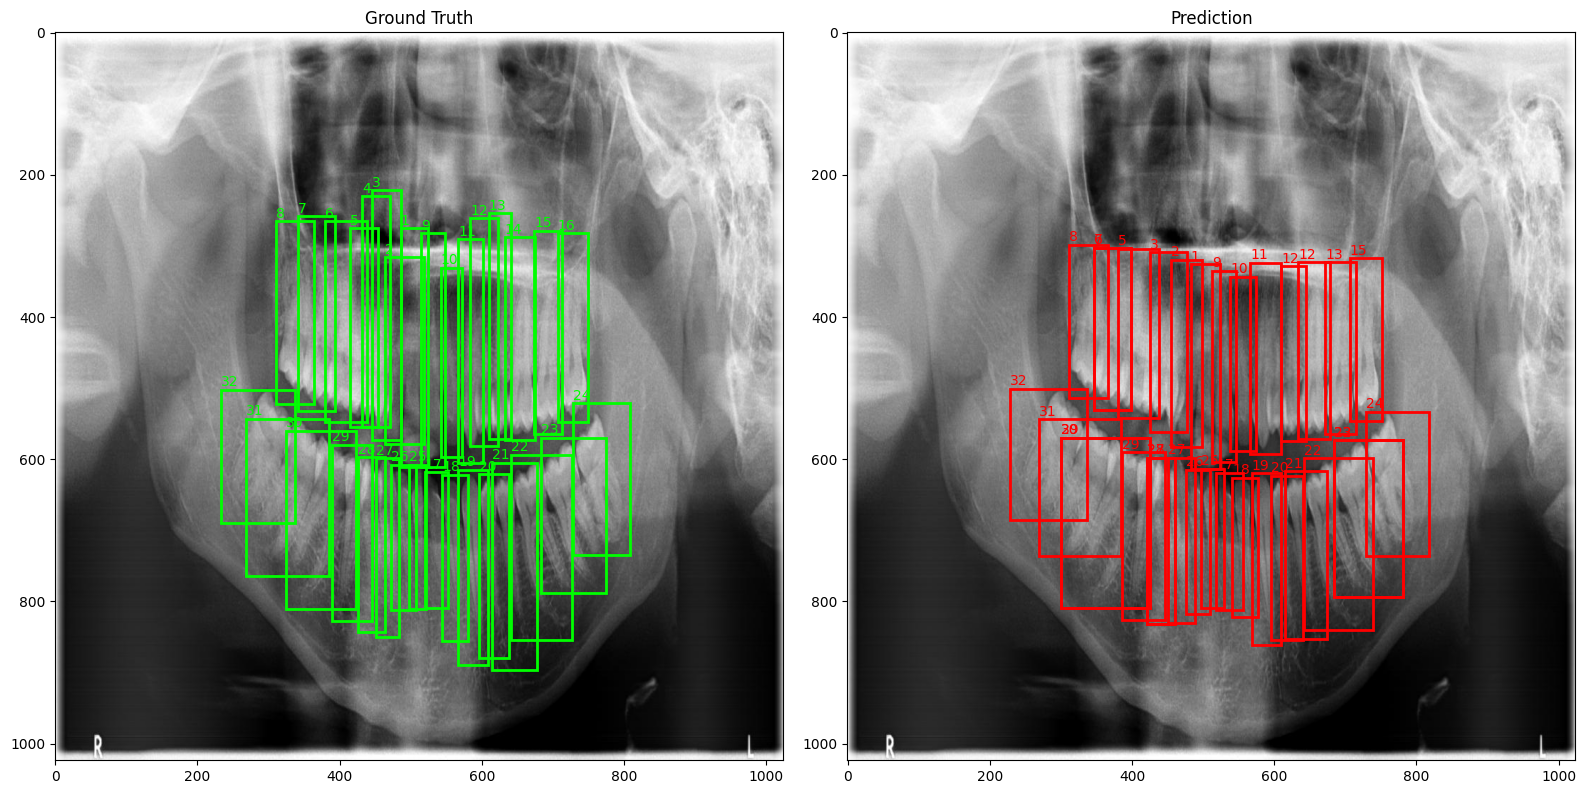

✅ Correct predictions: 23 / 32 ground truths


In [72]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import os

# Load ground truth and predictions
with open("/content/drive/MyDrive/enumeration32_Test/Dino_ResNet50/enum32_my_test.json", "r") as f:
    coco_gt_data = json.load(f)

with open("/content/drive/MyDrive/enumeration32_Test/Dino_ResNet50/enum32_pred_results.json", "r") as f:
    coco_pred_data = json.load(f)

# Index annotations by image ID
gt_by_image = {}
for ann in coco_gt_data["annotations"]:
    gt_by_image.setdefault(ann["image_id"], []).append(ann)

pred_by_image = {}
for ann in coco_pred_data:
    pred_by_image.setdefault(ann["image_id"], []).append(ann)

# Pick a random image
image_info = random.choice(coco_gt_data["images"])
image_id = image_info["id"]
file_name = image_info["file_name"]
width = image_info["width"]
height = image_info["height"]

# Load the image (edit path as needed)
image_dir = "/content/drive/MyDrive/enumeration32_Test/Dino_ResNet50/Dino_ResNet50_Test"
image_path = os.path.join(image_dir, file_name)
image = cv2.imread(image_path)
if image is None:
    image = np.ones((height, width, 3), dtype=np.uint8) * 255
else:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot GT and Prediction
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Ground Truth
axs[0].imshow(image)
axs[0].set_title("Ground Truth")
for ann in gt_by_image.get(image_id, []):
    x, y, w, h = ann["bbox"]
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none')
    axs[0].add_patch(rect)
    axs[0].text(x, y - 5, f"{ann['category_id']}", color='lime', fontsize=10)

# Prediction
axs[1].imshow(image)
axs[1].set_title("Prediction")
for ann in pred_by_image.get(image_id, []):
    x, y, w, h = ann["bbox"]
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
    axs[1].add_patch(rect)
    axs[1].text(x, y - 5, f"{ann['category_id']}", color='red', fontsize=10)

plt.tight_layout()
plt.show()
gt_anns = gt_by_image.get(image_id, [])
pred_anns = pred_by_image.get(image_id, [])
correct = count_correct_predictions(gt_anns, pred_anns)

print(f"✅ Correct predictions: {correct} / {len(gt_anns)} ground truths")
